In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

zip_path = '/content/drive/MyDrive/Colab Notebooks/assignment3.zip'
extract_path = '/content/'

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(extract_path)

Mounted at /content/drive
/content/


In [ ]:
!mv assignment3/* .

In [ ]:
!bash get_dataset.sh

--2025-05-21 21:33:49--  https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_base.zip
Resolving cmp.felk.cvut.cz (cmp.felk.cvut.cz)... 147.32.84.2
Connecting to cmp.felk.cvut.cz (cmp.felk.cvut.cz)|147.32.84.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36517004 (35M) [application/zip]
Saving to: ‘CMP_facade_DB_base.zip’

CMP_facade_DB_base. 100%[===================>]  34.83M   110MB/s    in 0.3s    

2025-05-21 21:33:49 (110 MB/s) - ‘CMP_facade_DB_base.zip’ saved [36517004/36517004]

--2025-05-21 21:33:49--  https://cmp.felk.cvut.cz/~tylecr1/facade/CMP_facade_DB_extended.zip
Resolving cmp.felk.cvut.cz (cmp.felk.cvut.cz)... 147.32.84.2
Connecting to cmp.felk.cvut.cz (cmp.felk.cvut.cz)|147.32.84.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20309906 (19M) [application/zip]
Saving to: ‘CMP_facade_DB_extended.zip’

CMP_facade_DB_exten 100%[===================>]  19.37M  87.8MB/s    in 0.2s    

2025-05-21 21:33:50 (87.8 MB/s) -

# Assignment 3: Pytorch Segmentation + CAM
For this assignment, in the first part, we're going to use Deep Learning for a new task: semantic segmentation. In the second part, you will interpret networks with the class activation map (CAM) as discussed in classes.

## Short recap of  semantic segmentation
The goal of semantic segmentation is to classify each pixel of the image to a corresponding class of what the pixel represent. One major diference between semantic segmentation and classification is that for semantic segmentation, model output a label for each pixel instead of a single label for the whole image.

## CMP Facade Database and Visualize Samples
In this assignment, we use a new dataset named: CMP Facade Database for semantic segmentation. This dataset is made up with 606 rectified images of the facade of various buildings. The facades are from different cities arount the world with different architectural styles.

CMP Facade DB include 12 semantic classes:

* facade
* molding
* cornice
* pillar
* window
* door
* sill
* blind
* balcony
* shop
* deco
* background

In this assignment, we should use a model to classify each pixel in images to one of these 12 classes.

For more detail about CMP Facade Dataset, if you are intereseted, please check: https://cmp.felk.cvut.cz/~tylecr1/facade/

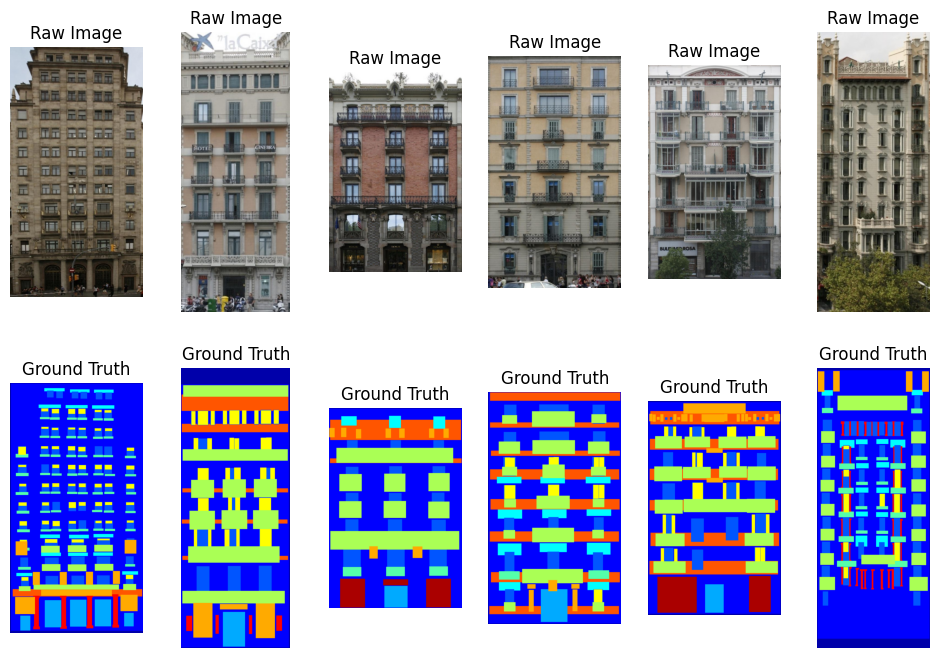

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

idxs = [1, 2, 5, 6, 7, 8]
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(12, 8))
for i, idx in enumerate(idxs):
    pic = plt.imread("dataset/base/cmp_b000{}.jpg".format(idx))
    label = plt.imread("dataset/base/cmp_b000{}.png".format(idx), format="PNG")

    axes[0][i].axis('off')
    axes[0][i].imshow(pic)
    axes[0][i].set_title("Raw Image")

    axes[1][i].imshow(label)
    axes[1][i].axis('off')
    axes[1][i].set_title("Ground Truth")

## Build Dataloader and Set Up Device

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as dset
import torchvision.transforms as T
import PIL
from PIL import Image
import numpy as np
import os
# import os.path as osp

from FCN.dataset import CMP_Facade_DB

os.environ["CUDA_VISIBLE_DEVICES"]="0"


def get_full_list(
    root_dir,
    base_dir="base",
    extended_dir="extended",
):
    data_list = []
    for name in [base_dir, extended_dir]:
        data_dir = os.path.join(
            root_dir, name
        )
        data_list += sorted(
            os.path.join(data_dir, img_name) for img_name in
            filter(
                lambda x: x[-4:] == '.jpg',
                os.listdir(data_dir)
            )
        )
    return data_list

TRAIN_SIZE = 500
VAL_SIZE = 30
TEST_SIZE = 70
full_data_list = get_full_list("dataset")

train_data_set = CMP_Facade_DB(full_data_list[: TRAIN_SIZE])
val_data_set = CMP_Facade_DB(full_data_list[TRAIN_SIZE: TRAIN_SIZE + VAL_SIZE])
test_data_set = CMP_Facade_DB(full_data_list[TRAIN_SIZE + VAL_SIZE:])

print("Training Set Size:", len(train_data_set))
print("Validation Set Size:", len(val_data_set))
print("Test Set Size:", len(test_data_set))

train_loader = torch.utils.data.DataLoader(
    train_data_set, batch_size=1, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_data_set, batch_size=1, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    test_data_set, batch_size=1, shuffle=False
)



USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

Training Set Size: 500
Validation Set Size: 30
Test Set Size: 76
using device: cuda


## Fully Convolutional Networks for Semantic Segmentation

Here we are going to explore the classical work: "Fully Convolutional Networks for Semantic Segmentation"(FCN).

In FCN, the model uses the Transpose Convolution layers, which we've already learned during the lecture, to recover high resolution feature maps. For the overall introduction of Transpose Convolution and Fully Convolutional Networks, please review the lecture recording and lecture slides on Canvas(Lecture 10).

Here we do not cover all the details in FCN. Please check the original paper: https://arxiv.org/pdf/1411.4038.pdf for more details.

Besides of transpose Convolution, there are also some differences compared with the models we've been working on:

* Use 1x1 Convolution to replace fully connected layers to output score for each class.
* Use skip connection to combine high-level feature and local feature.


# Part 1: FCN-32s (20%)

In this section, we first try to implement simple version of FCN without skip connection (i.e., FCN-32s) with VGG-16 as the backbone.

Compared with VGG-16, FCN-32s
* replaces the fully connecteed layers with 1x1 convolution
* adds a Transpose Convolution at the end to output dense prediction.

Task:
1. Complete FCN-32s in the notebook as instructed.
2. Train FCN-32s for 10 epochs and record the best model. Visualize the prediction results and report the test accuracy.
3. Train FCN-32s for 20 epochs with pretrained VGG-16 weights and record the best model. Visualize the prediction results and report the test accuracy.

## 1.1 Complete the FC-32s architecture:

The following Conv use kernel size = 3, padding = 1, stride =1 (except for conv1_1 where conv1_1 should use padding = 100)

* [conv1_1(3,64)-relu] -> [conv1_2(64,64)-relu] -> [maxpool1(2,2)]
* [conv2_1(64,128)-relu] -> [conv2_2(128,128)-relu] -> [maxpool2(2,2)]
* [conv3_1(128,256)-relu] -> [conv3_2(256,256)-relu] ->[conv3_3(256,256)-relu] ->  [maxpool3(2,2)]
* [conv4_1(256,512)-relu] -> [conv4_2(512,512)-relu] ->[conv4_3(512,512)-relu] ->  [maxpool4(2,2)]
* [conv5_1(512,512)-relu] -> [conv5_2(512,512)-relu] ->[conv5_3(512,512)-relu] ->  [maxpool5(2,2)]

The following Conv use stride = 1, padding = 0 (KxK denotes kernel size, dropout probability=0.5)
* [fc6=conv7x7(512, 4096)-relu-dropout2d]
* [fc7=conv1x1(4096, 4096)-relu-dropout2d]
* [score=conv1x1(4096, num_classes)]

The transpose convolution: kernal size = 64, stride = 32, bias = False
* [transpose_conv(n_class, n_class)]

**Hint: The output of the transpose convolution might not have the same shape as the input,
    take [19: 19 + input_image_width], [19: 19 + input_image_height] for width and height dimension
    of the output to get the output with the same shape as the input**

In [ ]:



class FCN32s(nn.Module):
    def __init__(self, n_class=21):
        super(FCN32s, self).__init__()
        ################################################################################
        # TODO: Implement the layers for FCN32s.                                       #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ############################################################################
        # conv1
        self.conv1_1 = nn.Conv2d(3,   64, kernel_size=3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64,  64, kernel_size=3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1   = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        # conv2
        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128,128, kernel_size=3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2   = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        # conv3
        self.conv3_1 = nn.Conv2d(128,256, kernel_size=3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256,256, kernel_size=3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256,256, kernel_size=3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3   = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        # conv4
        self.conv4_1 = nn.Conv2d(256,512, kernel_size=3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512,512, kernel_size=3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512,512, kernel_size=3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4   = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        # conv5
        self.conv5_1 = nn.Conv2d(512,512, kernel_size=3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512,512, kernel_size=3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512,512, kernel_size=3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5   = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        # fc6 / fc7  (conv7×7 + conv1×1)
        self.fc6   = nn.Conv2d(512, 4096, kernel_size=7, padding=0)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d(p=0.5)

        self.fc7   = nn.Conv2d(4096, 4096, kernel_size=1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d(p=0.5)

        # score layer
        self.score = nn.Conv2d(4096, n_class, kernel_size=1)

        # 32× up-sampling (transpose-conv/bilinear init)
        self.upscore = nn.ConvTranspose2d(
            n_class, n_class,
            kernel_size=64,
            stride=32,
            padding=16,
            bias=False
        )



        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        self._initialize_weights()

    def get_upsampling_weight(self, in_channels, out_channels, kernel_size):
        """Make a 2D bilinear kernel suitable for upsampling"""
        factor = (kernel_size + 1) // 2
        if kernel_size % 2 == 1:
            center = factor - 1
        else:
            center = factor - 0.5
        og = np.ogrid[:kernel_size, :kernel_size]
        filt = (1 - abs(og[0] - center) / factor) * \
               (1 - abs(og[1] - center) / factor)
        weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                          dtype=np.float64)
        weight[range(in_channels), range(out_channels), :, :] = filt
        return torch.from_numpy(weight).float()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.zero_()
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = self.get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)

    def forward(self, x):
        ################################################################################
        # TODO: Implement the forward pass for FCN32s.                                 #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        input_h, input_w = x.size(2), x.size(3)
        # VGG-16 encoder
        h = self.relu1_1(self.conv1_1(x))
        h = self.relu1_2(self.conv1_2(h))
        h = self.pool1(h)

        h = self.relu2_1(self.conv2_1(h))
        h = self.relu2_2(self.conv2_2(h))
        h = self.pool2(h)

        h = self.relu3_1(self.conv3_1(h))
        h = self.relu3_2(self.conv3_2(h))
        h = self.relu3_3(self.conv3_3(h))
        h = self.pool3(h)

        h = self.relu4_1(self.conv4_1(h))
        h = self.relu4_2(self.conv4_2(h))
        h = self.relu4_3(self.conv4_3(h))
        h = self.pool4(h)

        h = self.relu5_1(self.conv5_1(h))
        h = self.relu5_2(self.conv5_2(h))
        h = self.relu5_3(self.conv5_3(h))
        h = self.pool5(h)

        h = self.drop6(self.relu6(self.fc6(h)))
        h = self.drop7(self.relu7(self.fc7(h)))
        h = self.score(h)

        h = self.upscore(h)
        _, _, Hup, Wup = h.size()
        dh, dw = Hup - input_h, Wup - input_w
        top, left = dh // 2, dw // 2

        h = h[:, :, top: top + input_h,
                  left: left + input_w]

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return h


    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1, self.relu1_1,
            self.conv1_2, self.relu1_2,
            self.pool1,
            self.conv2_1, self.relu2_1,
            self.conv2_2, self.relu2_2,
            self.pool2,
            self.conv3_1, self.relu3_1,
            self.conv3_2, self.relu3_2,
            self.conv3_3, self.relu3_3,
            self.pool3,
            self.conv4_1, self.relu4_1,
            self.conv4_2, self.relu4_2,
            self.conv4_3, self.relu4_3,
            self.pool4,
            self.conv5_1, self.relu5_1,
            self.conv5_2, self.relu5_2,
            self.conv5_3, self.relu5_3,
            self.pool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data = l1.weight.data
                l2.bias.data = l1.bias.data
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data = l1.weight.data.view(l2.weight.size())
            l2.bias.data = l1.bias.data.view(l2.bias.size())


## 1.2  Train FCN-32s from scratch

In [ ]:
from FCN.trainer import Trainer

model32 = FCN32s(n_class=12)
model32.to(device)

best_model = Trainer(
    model32,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=10
)

Init Model
Avg Acc: 0.2307, Mean IoU: 0.01922
Epochs: 0
Epoch Loss: 2.43, Avg Acc: 0.3431, Mean IoU: 0.02859
Epochs: 1
Epoch Loss: 2.199, Avg Acc: 0.3431, Mean IoU: 0.02859
Epochs: 2
Epoch Loss: 2.001, Avg Acc: 0.3431, Mean IoU: 0.02859
Epochs: 3
Epoch Loss: 1.938, Avg Acc: 0.3431, Mean IoU: 0.02859
Epochs: 4
Epoch Loss: 1.927, Avg Acc: 0.3431, Mean IoU: 0.02859
Epochs: 5
Epoch Loss: 1.923, Avg Acc: 0.3431, Mean IoU: 0.02859
Epochs: 6
Epoch Loss: 1.921, Avg Acc: 0.3431, Mean IoU: 0.02859
Epochs: 7
Epoch Loss: 1.919, Avg Acc: 0.3431, Mean IoU: 0.02859
Epochs: 8
Epoch Loss: 1.918, Avg Acc: 0.3431, Mean IoU: 0.02859
Epochs: 9
Epoch Loss: 1.917, Avg Acc: 0.3431, Mean IoU: 0.02859
Test Acc: 0.3431, Test Mean IoU: 0.02859


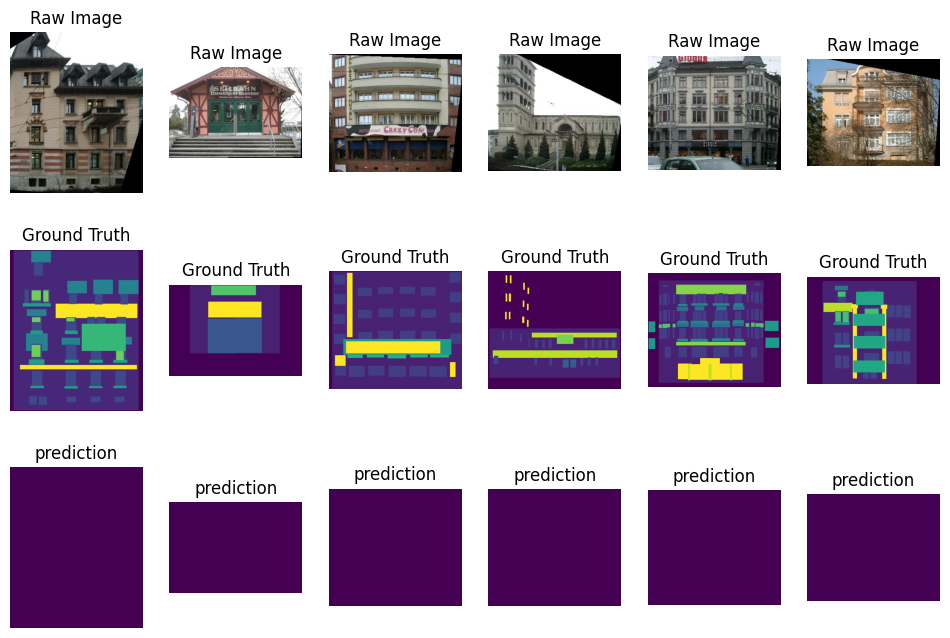

In [ ]:
from FCN.trainer import visualize
visualize(best_model, test_loader)

## 1.3 Train FCN-32s with the pretrained VGG16 weights

In [ ]:
import torchvision
from FCN.trainer import Trainer

vgg16 = torchvision.models.vgg16(pretrained=True)

model32_pretrain = FCN32s(n_class=12)
model32_pretrain.copy_params_from_vgg16(vgg16)
model32_pretrain.to(device)

best_model_pretrain = Trainer(
    model32_pretrain,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=20
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 184MB/s]


Init Model
Avg Acc: 0.2307, Mean IoU: 0.01922
Epochs: 0
Epoch Loss: 1.633, Avg Acc: 0.4964, Mean IoU: 0.141
Epochs: 1
Epoch Loss: 1.38, Avg Acc: 0.493, Mean IoU: 0.1623
Epochs: 2
Epoch Loss: 1.279, Avg Acc: 0.5401, Mean IoU: 0.1947
Epochs: 3
Epoch Loss: 1.189, Avg Acc: 0.5557, Mean IoU: 0.2162
Epochs: 4
Epoch Loss: 1.101, Avg Acc: 0.5825, Mean IoU: 0.2612
Epochs: 5
Epoch Loss: 1.025, Avg Acc: 0.5786, Mean IoU: 0.2393
Epochs: 6
Epoch Loss: 0.9564, Avg Acc: 0.6032, Mean IoU: 0.2887
Epochs: 7
Epoch Loss: 0.8915, Avg Acc: 0.6044, Mean IoU: 0.2975
Epochs: 8
Epoch Loss: 0.8323, Avg Acc: 0.6053, Mean IoU: 0.2953
Epochs: 9
Epoch Loss: 0.7971, Avg Acc: 0.6145, Mean IoU: 0.3048
Epochs: 10
Epoch Loss: 0.7684, Avg Acc: 0.6237, Mean IoU: 0.3061
Epochs: 11
Epoch Loss: 0.7381, Avg Acc: 0.6233, Mean IoU: 0.3212
Epochs: 12
Epoch Loss: 0.6997, Avg Acc: 0.6315, Mean IoU: 0.3182
Epochs: 13
Epoch Loss: 0.6744, Avg Acc: 0.6305, Mean IoU: 0.3276
Epochs: 14
Epoch Loss: 0.644, Avg Acc: 0.6342, Mean IoU: 0.3326

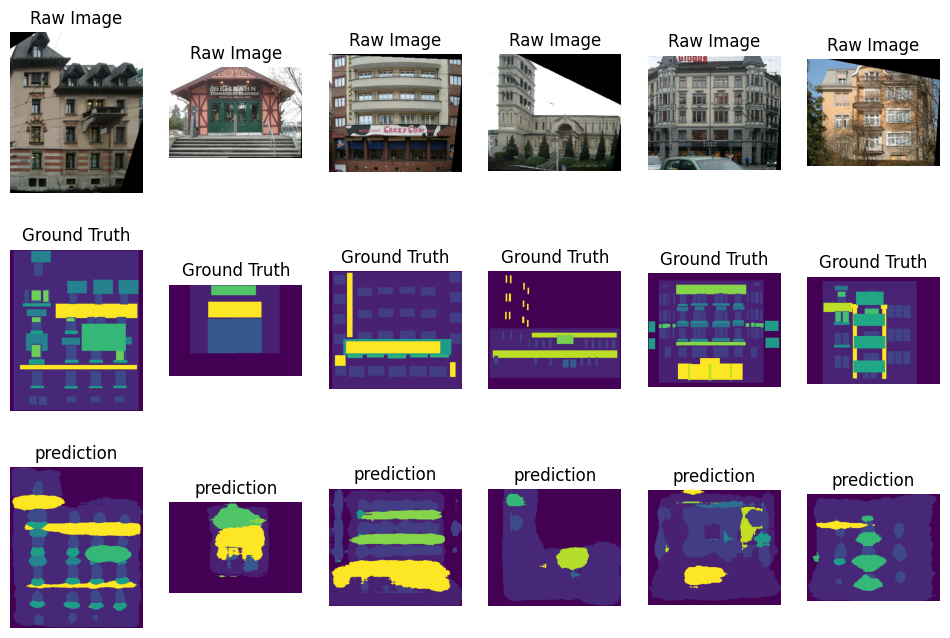

In [ ]:
from FCN.trainer import visualize
visualize(best_model_pretrain, test_loader)

# Part 2: FCN-8s(30%)

In this section, we explore with another technique introduced in FCN paper: Skip Connection.

Task: Read the paper and understand the skip connection, then
1. Complete FCN-8s in the notebook as instructed.
2. Train the network for 20 epochs with pretrained VGG-16 weights and record the best model. Visualize the prediction results and report the test accuracy.

## Here we provide the structure of FCN-8s, the variant of FCN with skip connections.

FCN-8s architecture:

The following Conv use kernel size = 3, padding = 1, stride =1 (except for conv1_1 where conv1_1 should use padding = 100)

**As you can see, the structure of this part is the same as FCN-32s**

* [conv1_1(3,64)-relu] -> [conv1_2(64,64)-relu] -> [maxpool1(2,2)]
* [conv2_1(64,128)-relu] -> [conv2_2(128,128)-relu] -> [maxpool2(2,2)]
* [conv3_1(128,256)-relu] -> [conv3_2(256,256)-relu] ->[conv3_3(256,256)-relu] ->  [maxpool3(2,2)]
* [conv4_1(256,512)-relu] -> [conv4_2(512,512)-relu] ->[conv4_3(512,512)-relu] ->  [maxpool4(2,2)]
* [conv5_1(512,512)-relu] -> [conv5_2(512,512)-relu] ->[conv5_3(512,512)-relu] ->  [maxpool5(2,2)]

The following Conv use stride = 1, padding = 0 (KxK denotes kernel size, dropout probability=0.5)
* [fc6=conv7x7(512, 4096)-relu-dropout2d]
* [fc7=conv1x1(4096, 4096)-relu-dropout2d]
* [score=conv1x1(4096, num_classes)]

The Additional Score Pool use kernel size = 1, stride = 1, padding = 0
* [score_pool_3 =conv1x1(256, num_classes)]
* [score_pool_4 =conv1x1(512, num_classes)]

The transpose convolution: kernal size = 4, stride = 2, bias = False
* [upscore1 = transpose_conv(n_class, n_class)]

The transpose convolution: kernal size = 4, stride = 2, bias = False
* [upscore2 = transpose_conv(n_class, n_class)]

The transpose convolution: kernal size = 16, stride = 8, bias = False
* [upscore3 = transpose_conv(n_class, n_class)]


Different from FCN-32s which has only single path from input to output, there are multiple data path from input to output in FCN-8s.

The following graph is from original FCN paper, you can also find the graph there.

!["Architecture Graph"](files/arch.png)
"Layers are shown as grids that reveal relative spatial coarseness. Only pooling and prediction layers are shown; intermediate convolution layers (including converted fully connected layers) are omitted. " ---- FCN

Detailed path specification:

* score_pool_3
    * input: output from layer "pool3"
    * take [9: 9 + upscore2_width], [9: 9 + upscore2_height]
    
* score_pool_4,
    * input: output from layer "pool4"
    * take [5: 5 + upscore1_width], [5: 5 + upscore1_height]


* upscore1
    * input: output from layer "score"

* upscore2:
    * input: output from layer "score_pool_4" + output from layer "upscore1"

* upscore3:
    * input: output from layer "score_pool_3" + output from layer "upscore2"
    * take [31: 31 + input_image_width], [31: 31 + input_image_height]


In [ ]:
import torch.nn as nn

class FCN8s(nn.Module):

    def __init__(self, n_class=12):
        super(FCN8s, self).__init__()

        ################################################################################
        # TODO: Implement the layers for FCN8s.                                        #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # conv1
        self.conv1_1 = nn.Conv2d(3, 64, 3, padding=100)
        self.relu1_1 = nn.ReLU(inplace=True)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.relu1_2 = nn.ReLU(inplace=True)
        self.pool1   = nn.MaxPool2d(2, 2, ceil_mode=True)

        # conv2
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2_1 = nn.ReLU(inplace=True)
        self.conv2_2 = nn.Conv2d(128,128, 3, padding=1)
        self.relu2_2 = nn.ReLU(inplace=True)
        self.pool2   = nn.MaxPool2d(2, 2, ceil_mode=True)

        # conv3
        self.conv3_1 = nn.Conv2d(128,256, 3, padding=1)
        self.relu3_1 = nn.ReLU(inplace=True)
        self.conv3_2 = nn.Conv2d(256,256, 3, padding=1)
        self.relu3_2 = nn.ReLU(inplace=True)
        self.conv3_3 = nn.Conv2d(256,256, 3, padding=1)
        self.relu3_3 = nn.ReLU(inplace=True)
        self.pool3   = nn.MaxPool2d(2, 2, ceil_mode=True)

        # conv4
        self.conv4_1 = nn.Conv2d(256,512, 3, padding=1)
        self.relu4_1 = nn.ReLU(inplace=True)
        self.conv4_2 = nn.Conv2d(512,512, 3, padding=1)
        self.relu4_2 = nn.ReLU(inplace=True)
        self.conv4_3 = nn.Conv2d(512,512, 3, padding=1)
        self.relu4_3 = nn.ReLU(inplace=True)
        self.pool4   = nn.MaxPool2d(2, 2, ceil_mode=True)

        # conv5
        self.conv5_1 = nn.Conv2d(512,512, 3, padding=1)
        self.relu5_1 = nn.ReLU(inplace=True)
        self.conv5_2 = nn.Conv2d(512,512, 3, padding=1)
        self.relu5_2 = nn.ReLU(inplace=True)
        self.conv5_3 = nn.Conv2d(512,512, 3, padding=1)
        self.relu5_3 = nn.ReLU(inplace=True)
        self.pool5   = nn.MaxPool2d(2, 2, ceil_mode=True)

        self.fc6   = nn.Conv2d(512, 4096, 7)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout2d(0.5)

        self.fc7   = nn.Conv2d(4096, 4096, 1)
        self.relu7 = nn.ReLU(inplace=True)
        self.drop7 = nn.Dropout2d(0.5)

        self.score = nn.Conv2d(4096, n_class, 1)

        self.score_pool3 = nn.Conv2d(256, n_class, 1)
        self.score_pool4 = nn.Conv2d(512, n_class, 1)

        self.upscore1 = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, padding=1, bias=False)   # ×2
        self.upscore2 = nn.ConvTranspose2d(
            n_class, n_class, 4, stride=2, padding=1, bias=False)   # ×2
        self.upscore3 = nn.ConvTranspose2d(
            n_class, n_class, 16, stride=8, padding=4, bias=False)  # ×8

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        self._initialize_weights()

    def get_upsampling_weight(self, in_channels, out_channels, kernel_size):
        """Make a 2D bilinear kernel suitable for upsampling"""
        factor = (kernel_size + 1) // 2
        if kernel_size % 2 == 1:
            center = factor - 1
        else:
            center = factor - 0.5
        og = np.ogrid[:kernel_size, :kernel_size]
        filt = (1 - abs(og[0] - center) / factor) * \
               (1 - abs(og[1] - center) / factor)
        weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size),
                          dtype=np.float64)
        weight[range(in_channels), range(out_channels), :, :] = filt
        return torch.from_numpy(weight).float()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.zero_()
                if m.bias is not None:
                    m.bias.data.zero_()
            if isinstance(m, nn.ConvTranspose2d):
                assert m.kernel_size[0] == m.kernel_size[1]
                initial_weight = self.get_upsampling_weight(
                    m.in_channels, m.out_channels, m.kernel_size[0])
                m.weight.data.copy_(initial_weight)


    def forward(self, x):
        ################################################################################
        # TODO: Implement the forward pass for FCN8s.                                 #
        ################################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        h, w = x.size(2), x.size(3)

        o = self.relu1_1(self.conv1_1(x))
        o = self.relu1_2(self.conv1_2(o));   o = self.pool1(o)

        o = self.relu2_1(self.conv2_1(o))
        o = self.relu2_2(self.conv2_2(o));   o = self.pool2(o)

        o = self.relu3_1(self.conv3_1(o))
        o = self.relu3_2(self.conv3_2(o))
        o = self.relu3_3(self.conv3_3(o));   pool3 = self.pool3(o)  # 1/8

        o = self.relu4_1(self.conv4_1(pool3))
        o = self.relu4_2(self.conv4_2(o))
        o = self.relu4_3(self.conv4_3(o));   pool4 = self.pool4(o)  # 1/16

        o = self.relu5_1(self.conv5_1(pool4))
        o = self.relu5_2(self.conv5_2(o))
        o = self.relu5_3(self.conv5_3(o));   o = self.pool5(o) # 1/32


        o = self.drop6(self.relu6(self.fc6(o)))
        o = self.drop7(self.relu7(self.fc7(o)))
        score_fr = self.score(o)

        upscore1 = self.upscore1(score_fr)
        score_p4 = self.score_pool4(pool4)
        score_p4 = self._crop(score_p4, upscore1)
        fuse_p4  = upscore1 + score_p4

        upscore2 = self.upscore2(fuse_p4)
        score_p3 = self.score_pool3(pool3)
        score_p3 = self._crop(score_p3, upscore2)
        fuse_p3  = upscore2 + score_p3

        upscore3 = self.upscore3(fuse_p3)
        h_out    = self._crop(upscore3,
                              torch.empty(1, 1, h, w, device=upscore3.device))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        ################################################################################
        #                                 END OF YOUR CODE                             #
        ################################################################################

        return h_out

    def _crop(self, src, tgt):

        _, _, h, w = tgt.size()
        _, _, H, W = src.size()

        dh = (H - h) // 2
        dw = (W - w) // 2
        return src[:, :, dh:dh + h, dw:dw + w]

    def copy_params_from_vgg16(self, vgg16):
        features = [
            self.conv1_1, self.relu1_1,
            self.conv1_2, self.relu1_2,
            self.pool1,
            self.conv2_1, self.relu2_1,
            self.conv2_2, self.relu2_2,
            self.pool2,
            self.conv3_1, self.relu3_1,
            self.conv3_2, self.relu3_2,
            self.conv3_3, self.relu3_3,
            self.pool3,
            self.conv4_1, self.relu4_1,
            self.conv4_2, self.relu4_2,
            self.conv4_3, self.relu4_3,
            self.pool4,
            self.conv5_1, self.relu5_1,
            self.conv5_2, self.relu5_2,
            self.conv5_3, self.relu5_3,
            self.pool5,
        ]
        for l1, l2 in zip(vgg16.features, features):
            if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                assert l1.weight.size() == l2.weight.size()
                assert l1.bias.size() == l2.bias.size()
                l2.weight.data.copy_(l1.weight.data)
                l2.bias.data.copy_(l1.bias.data)
        for i, name in zip([0, 3], ['fc6', 'fc7']):
            l1 = vgg16.classifier[i]
            l2 = getattr(self, name)
            l2.weight.data.copy_(l1.weight.data.view(l2.weight.size()))
            l2.bias.data.copy_(l1.bias.data.view(l2.bias.size()))


In [ ]:
from FCN.trainer import Trainer
import torchvision

vgg16 = torchvision.models.vgg16(pretrained=True)

model8 = FCN8s(n_class=12)
model8.copy_params_from_vgg16(vgg16)
model8.to(device)

best_model_fcn8s = Trainer(
    model8,
    train_loader,
    val_loader,
    test_loader,
    num_epochs=20
)

Init Model
Avg Acc: 0.2307, Mean IoU: 0.01922
Epochs: 0
Epoch Loss: 1.222, Avg Acc: 0.6172, Mean IoU: 0.3169
Epochs: 1
Epoch Loss: 0.9998, Avg Acc: 0.6349, Mean IoU: 0.3594
Epochs: 2
Epoch Loss: 0.9062, Avg Acc: 0.6346, Mean IoU: 0.3318
Epochs: 3
Epoch Loss: 0.8487, Avg Acc: 0.6771, Mean IoU: 0.3671
Epochs: 4
Epoch Loss: 0.8008, Avg Acc: 0.6441, Mean IoU: 0.3287
Epochs: 5
Epoch Loss: 0.7807, Avg Acc: 0.6928, Mean IoU: 0.3915
Epochs: 6
Epoch Loss: 0.6923, Avg Acc: 0.686, Mean IoU: 0.4019
Epochs: 7
Epoch Loss: 0.6213, Avg Acc: 0.6943, Mean IoU: 0.4123
Epochs: 8
Epoch Loss: 0.5786, Avg Acc: 0.7115, Mean IoU: 0.4264
Epochs: 9
Epoch Loss: 0.5305, Avg Acc: 0.7071, Mean IoU: 0.4277
Epochs: 10
Epoch Loss: 0.5026, Avg Acc: 0.7085, Mean IoU: 0.4246
Epochs: 11
Epoch Loss: 0.4785, Avg Acc: 0.7095, Mean IoU: 0.4101
Epochs: 12
Epoch Loss: 0.4463, Avg Acc: 0.7099, Mean IoU: 0.4137
Epochs: 13
Epoch Loss: 0.4213, Avg Acc: 0.7187, Mean IoU: 0.4554
Epochs: 14
Epoch Loss: 0.399, Avg Acc: 0.7167, Mean IoU:

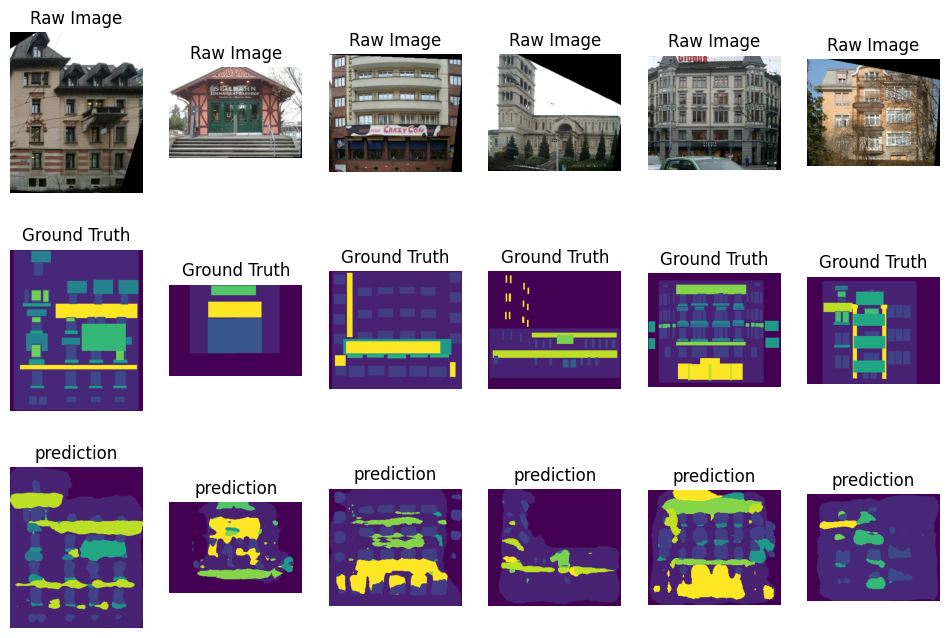

In [ ]:
from FCN.trainer import visualize
visualize(best_model_fcn8s, test_loader)

# Part 3:  Questions(20%):

#### Question 1: Compare the FCN-32s training from scratch with the FCN-32s with pretrained weights? What do you observe? Does pretrained weights help? Why? Please be as specific as possible.

### Your Answer:

- FCN-32s trained from scratch:

  After 10 epochs: pixel accuracy ≈ 34 %, mean IoU ≈ 0.03.

  Loss stops improving early.

- FCN-32s with ImageNet-pre-trained VGG-16 encoder:

  After the same 10 epochs: pixel accuracy ≈ 64 %, mean IoU ≈ 0.36.

  Loss keeps falling throughout training.

On a small semantic-segmentation data set, FCN-32s barely learns when trained from scratch. Re-using ImageNet weights transforms the same architecture into a viable segmenter, boosting mean IoU more than ten-fold and nearly doubling pixel-level accuracy after the first training run. For deep encoders, large-scale pre-training is practically essential when data are limited.


#### Question 2: Compare the performance and visualization of FCN-32s and FCN-8s (both with pretrained weights). What do you observe? Which performs better? Why? Please be as specific as possible.

### Your Answer:

FCN-8s beats FCN-32s:

- Mean IoU rises from 0.36 → 0.46 (≈ +0.10, ~28 % relative gain).

- Pixel accuracy climbs from 64 % → 72 % (≈ +8 pp).

- FCN-8s already reaches IoU ≈ 0.39 by epoch 5, a level FCN-32s only approaches near the end of its run.

Adding skip connections to create FCN-8s yields both crisper segmentation maps and higher numeric scores. The model's ability to fuse coarse semantics with fine geometry is the key reason it outperforms the simpler FCN-32s.

# Part 4: Class Activation Maps (30%)

In this section, we are going to interpret neural networks decisions with the technique class activation maps (CAM). As discussed in the class, the idea is that one can highlight the image region that is important to the prediction.

The resnet-18 uses global average pooling for downsampling layer 4 features and then applies an FC layer to predict the class probabilities. We select the class with the highest probability as our best guess and we denote the corresponding FC weight as $w$.

Let $f_4(x,y)$ denote the layer 4 feature at spatial location (x,y). Now we can directly apply the learned FC weight $w$ to $f_4(x,y)$ to get the network prediction for this spatial location $CAM(x,y)$. $CAM$ can be obtained by repeating this for all spatial locations.

You may refer to the paper (http://cnnlocalization.csail.mit.edu/Zhou_Learning_Deep_Features_CVPR_2016_paper.pdf) for more details. In this part, we are going to use the pretrained resnet18 as the backbone.

Task: understand the approach, then
1. For each image, show the top-1 class prediction and probability.
2. For each image, plot the CAM using layer4 features and fc weights (corresponding to the top-1 prediction).


In [ ]:
def get_cls_pred(logit):
    """
    Input:
        logit: (1, 1000) # the predicted logits from resnet18
    Output:
        cls_idx: (1, ) # the class index with highest probability
    """

    # load the imagenet category list
    LABELS_file = 'files/imagenet-simple-labels.json'
    with open(LABELS_file) as f:
        classes = json.load(f)

    ################################################################################
    # TODO:
    #      1. Use softmax to get the class prediction probability from logits
    #      2. Use torch.sort to get the top-1 class prediction probability (top1_prob)
    #         and the corresponding class index (top1_idx)
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # 1. probabilities
    probs = F.softmax(logit, dim=1)                          # (1,1000)

    # 2. top-1 score and index
    top1_prob, top1_idx = probs.topk(1, dim=1)               # both (1,1)
    top1_prob = top1_prob.item()
    top1_idx  = top1_idx.item()



    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################

    # output the prediction
    print('top1 prediction: {:.3f} -> {}'.format(top1_prob, classes[top1_idx]))

    return top1_idx


def returnCAM(feature_conv, weight_fc, idx):
    """
    Input:
        feature_conv: (1, 512, 7, 7) # layer4 feature
        weight_fc: (1000, 512) # fc weight
        idx: (1, ) # predicted class index
    Output:
        output_cam: (256, 256)
    """
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape

    ################################################################################
    # TODO: Implement CAM
    #     1. the product of the layer4 features and the fc weight corresponding to
    #        the top-1 class prediction
    #     2. convert to cam_img of shape (7,7) and value range [0, 255]
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # use the fc weights of the predicted class (shape: 512,)
    cam = weight_fc[idx].dot(feature_conv.reshape(nc, h * w))   # (49,)
    cam = cam.reshape(h, w)

    # normalise to [0,255] for visualisation
    cam -= cam.min()
    cam /= cam.max() + 1e-8
    cam_img = np.uint8(255 * cam)




    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################

    # resize cam image to (256,256)
    output_cam = cv2.resize(cam_img, size_upsample)

    return output_cam

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


load pretrained weights


100%|██████████| 44.7M/44.7M [00:00<00:00, 389MB/s]


top1 prediction: 0.443 -> mountain bike


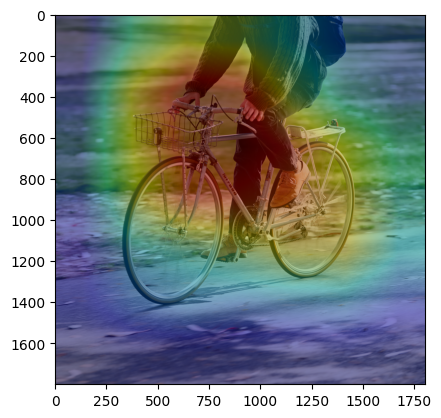

top1 prediction: 0.368 -> tabby cat


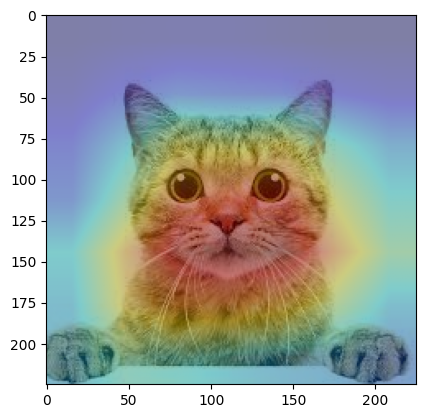

In [ ]:
import io
from PIL import Image
from torchvision import transforms
from torch.nn import functional as F
import numpy as np
import cv2
import json
from CAM.resnet import resnet18
import matplotlib.pyplot as plt


# load model
net = resnet18(pretrained=True)
net.eval()

# image normalization
preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225])
])

# load the imagenet category list
LABELS_file = 'files/imagenet-simple-labels.json'
with open(LABELS_file) as f:
    classes = json.load(f)

# load test image files/bike.jpg, files/
for image_file in ['files/bike.jpg', 'files/cat.jpg']:
    img = Image.open(image_file)
    img_tensor = preprocess(img)

    # extract predicted logits and layer4 feature
    logits, layer4_feat = net(img_tensor.unsqueeze(0))
    layer4_feat = layer4_feat.detach().numpy()

    # predicted top-1 class, needs to complete the function
    cls_idx = get_cls_pred(logits)

    ################################################################################
    # TODO: extract the weight of fc layer and convert from torch.tensor to numpy.array                                                         #
    ################################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    # weight_fc =  # weight_fc is of shape (1000, 512)
    weight_fc = net.fc.weight.detach().cpu().numpy()


    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################


    # generate class activation mapping for the top1 prediction
    CAMs = returnCAM(layer4_feat, weight_fc, cls_idx)

    # render the CAM and output
    img = cv2.imread(image_file)
    height, width, _ = img.shape
    heatmap = cv2.applyColorMap(cv2.resize(CAMs,(width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.3 + img * 0.5
    plt.imshow(result[:,:,::-1]/255)
    plt.show()